# Importando bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib, os, pickle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import chi2_contingency

In [2]:
pd.set_option('display.max_columns', 90)
pd.set_option('display.max_rows', 100)

# Lendo dataset

In [3]:
file_path = r'C:\Users\GabGalani\Documents\Data Projects\Analise_credito\dataset\silver\silver_test.csv'
dataset = pd.read_csv(file_path, sep=';')
dataset.head(2)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,0x16295,CUS_0x1000,December,Alistair Barrf,18,913-74-1218,Lawyer,30625.0,2706.161667,6,5,27.0,2,"Credit-Builder Loan, and Home Equity Loan",62,25,1.63,11,Bad,1562.91,27.020942,11 Years and 1 Months,Yes,42.94109,183.857677,High_spent_Small_value_payments,303.817399
1,0x16294,CUS_0x1000,November,Alistair Barrf,18,913-74-1218,Lawyer,30625.0,2706.161667,6,5,27.0,2,"Credit-Builder Loan, and Home Equity Loan",62,25,4.63,11,Bad,1562.91,25.767921,11 Years and 0 Months,Yes,42.94109,150.871474,Low_spent_Medium_value_payments,356.803602


# Excluindo colunas irrelevantes

In [4]:
dataset.drop(['ID', 'Customer_ID', 'Month', 'Name', 'SSN', 'Type_of_Loan'], axis=1, inplace=True)
dataset.head(2)

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,18,Lawyer,30625.0,2706.161667,6,5,27.0,2,62,25,1.63,11,Bad,1562.91,27.020942,11 Years and 1 Months,Yes,42.94109,183.857677,High_spent_Small_value_payments,303.817399
1,18,Lawyer,30625.0,2706.161667,6,5,27.0,2,62,25,4.63,11,Bad,1562.91,25.767921,11 Years and 0 Months,Yes,42.94109,150.871474,Low_spent_Medium_value_payments,356.803602


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       50000 non-null  int64  
 1   Occupation                50000 non-null  object 
 2   Annual_Income             50000 non-null  float64
 3   Monthly_Inhand_Salary     50000 non-null  float64
 4   Num_Bank_Accounts         50000 non-null  int64  
 5   Num_Credit_Card           50000 non-null  int64  
 6   Interest_Rate             50000 non-null  float64
 7   Num_of_Loan               50000 non-null  int64  
 8   Delay_from_due_date       50000 non-null  int64  
 9   Num_of_Delayed_Payment    50000 non-null  int64  
 10  Changed_Credit_Limit      50000 non-null  float64
 11  Num_Credit_Inquiries      50000 non-null  int64  
 12  Credit_Mix                50000 non-null  object 
 13  Outstanding_Debt          50000 non-null  float64
 14  Credit

In [6]:
# Converter diretamente com split
def convert_age_to_months_simple(age_str):
    years, months = age_str.split(" Years and ")
    months = months.replace(" Months", "")
    return int(years) * 12 + int(months)

dataset['Credit_History_Age'] = dataset['Credit_History_Age'].apply(convert_age_to_months_simple)
dataset.head(2)

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,18,Lawyer,30625.0,2706.161667,6,5,27.0,2,62,25,1.63,11,Bad,1562.91,27.020942,133,Yes,42.94109,183.857677,High_spent_Small_value_payments,303.817399
1,18,Lawyer,30625.0,2706.161667,6,5,27.0,2,62,25,4.63,11,Bad,1562.91,25.767921,132,Yes,42.94109,150.871474,Low_spent_Medium_value_payments,356.803602


# Análise gráfica dos dados

## Verificando correlação

Correlação da variável alvo com as variáveis numericas

In [7]:
encoder = LabelEncoder()
df_variavel_alvo = dataset.drop(['Payment_Behaviour', 'Payment_of_Min_Amount', 'Occupation'], axis=1)
df_variavel_alvo['Credit_Mix'] = encoder.fit_transform(df_variavel_alvo['Credit_Mix'])


In [8]:
# Calcular a correlação
correlation_matrix = df_variavel_alvo.corr()

# Mostrar a correlação da variável alvo com as demais
cor_target = correlation_matrix['Credit_Mix'].sort_values(ascending=False)
print(cor_target)

Credit_Mix                  1.000000
Credit_History_Age          0.315249
Monthly_Balance             0.140040
Age                         0.076842
Credit_Utilization_Ratio    0.032676
Monthly_Inhand_Salary       0.006208
Amount_invested_monthly     0.005948
Total_EMI_per_month         0.002096
Interest_Rate              -0.000200
Annual_Income              -0.000677
Num_Credit_Card            -0.001515
Num_Credit_Inquiries       -0.003522
Num_of_Delayed_Payment     -0.007262
Num_Bank_Accounts          -0.009181
Changed_Credit_Limit       -0.068785
Delay_from_due_date        -0.389255
Num_of_Loan                -0.417973
Outstanding_Debt           -0.547088
Name: Credit_Mix, dtype: float64


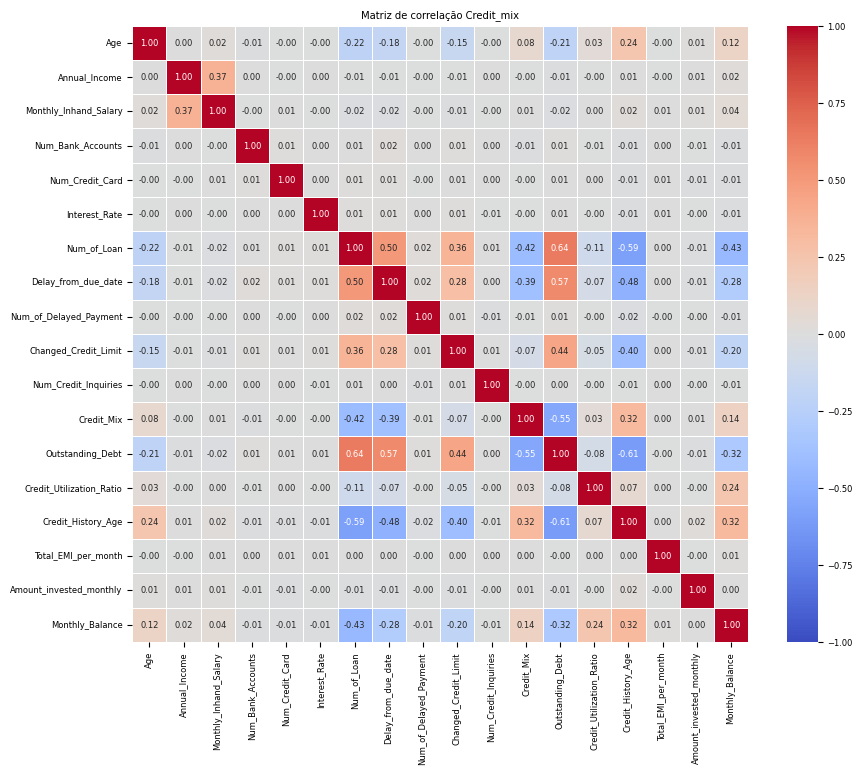

In [9]:
plt.figure(figsize = (10,8))
plt.rcParams.update({'font.size': 6})
sns.heatmap(correlation_matrix, cmap = 'coolwarm', vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5)
plt.title('Matriz de correlação Credit_mix')
plt.show()

Correlação tri-quadrada entre as variáveis categóricas

In [10]:
contingency_table = pd.crosstab(dataset['Credit_Mix'], dataset['Payment_Behaviour'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Payment_Behaviour - p-value: {p}")

Payment_Behaviour - p-value: 1.4821538735568483e-92


In [11]:
contingency_table = pd.crosstab(dataset['Credit_Mix'], dataset['Occupation'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Occupation - p-value: {p}")

Occupation - p-value: 1.5038460818726506e-10


In [12]:
contingency_table = pd.crosstab(dataset['Credit_Mix'], dataset['Payment_of_Min_Amount'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Payment_of_Min_Amount - p-value: {p}")

Payment_of_Min_Amount - p-value: 0.0


Analise: <br>
Campos a serem considerados para o modelo, devido ao valor da correlação: <br>
Credit_History_Age - Delay_from_due_date - Num_of_Loan - Outstanding_Debt - Monthly_Balance: <br> <br>

Campos a serem considerados para o mdelo, devido à multicorrelação entre variáveis: <br>
Age - Annual_Income - Monthly_Inhand_Salary <br> <br>

O restante das variáveis serão desconsideradas

Anaslise tri-quadrátrica
Os 3 campos analisados o P-valor, represeram uma forte ligação com a variável alvo, o que as manterão no modelo


In [13]:
colunas_correlatas = [
    'Credit_Mix',
    'Occupation',
    'Payment_Behaviour',
    'Payment_of_Min_Amount',
    'Age',
    'Credit_History_Age', 
    'Delay_from_due_date', 
    'Num_of_Loan', 
    'Outstanding_Debt', 
    'Monthly_Inhand_Salary',
    'Monthly_Balance', 
    'Annual_Income', 
]
dataset_correlacionado = dataset[colunas_correlatas]
dataset_correlacionado.head()

,Credit_Mix,Occupation,Payment_Behaviour,Payment_of_Min_Amount,Age,Credit_History_Age,Delay_from_due_date,Num_of_Loan,Outstanding_Debt,Monthly_Inhand_Salary,Monthly_Balance,Annual_Income
0,Bad,Lawyer,High_spent_Small_value_payments,Yes,18,133,62,2,1562.91,2706.161667,303.817399,30625.0
1,Bad,Lawyer,Low_spent_Medium_value_payments,Yes,18,132,62,2,1562.91,2706.161667,356.803602,30625.0
2,Bad,Lawyer,Low_spent_Small_value_payments,Yes,18,131,62,2,1562.91,2706.161667,349.977505,30625.0
3,Bad,Lawyer,Low_spent_Large_value_payments,Yes,18,130,65,2,1562.91,2706.161667,341.390178,17188404.0
4,Standard,Mechanic,High_spent_Medium_value_payments,Yes,26,376,8,4,202.68,4250.390000,441.878698,52312.0


## Outliers

Variável Age

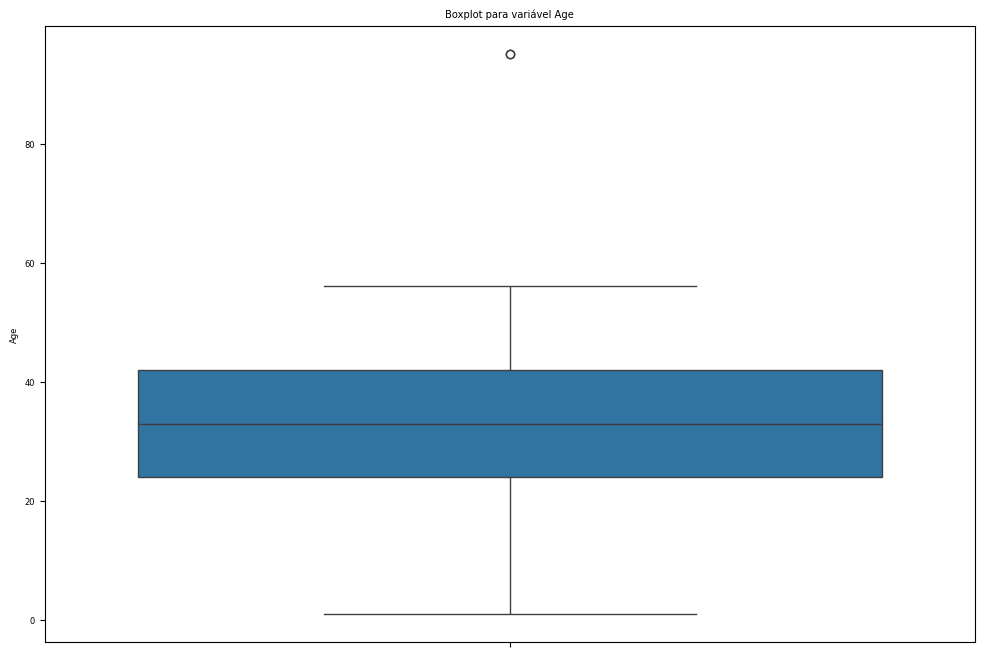

In [14]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=dataset_correlacionado['Age'])
plt.title("Boxplot para variável Age")
plt.xticks(rotation=45)
plt.show()

In [15]:
Q1 = dataset_correlacionado['Age'].quantile(0.25)
Q3 = dataset_correlacionado['Age'].quantile(0.75)
IQR = Q3 - Q1

# Limites superior e inferior para detectar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

quartis = dataset_correlacionado['Age'].describe().T[['25%', '50%', '75%', 'min', 'max']]

# Mostrar os quartis
print("Quartis das variáveis numéricas:")
print(quartis)

Quartis das variáveis numéricas:
25%    24.0
50%    33.0
75%    42.0
min     1.0
max    95.0
Name: Age, dtype: float64


In [16]:
dataset_correlacionado = dataset_correlacionado[(dataset_correlacionado['Age'] >= 16) & dataset_correlacionado['Age'] <= 60]

Retirados os outliers menores que 16 e maiores que 60

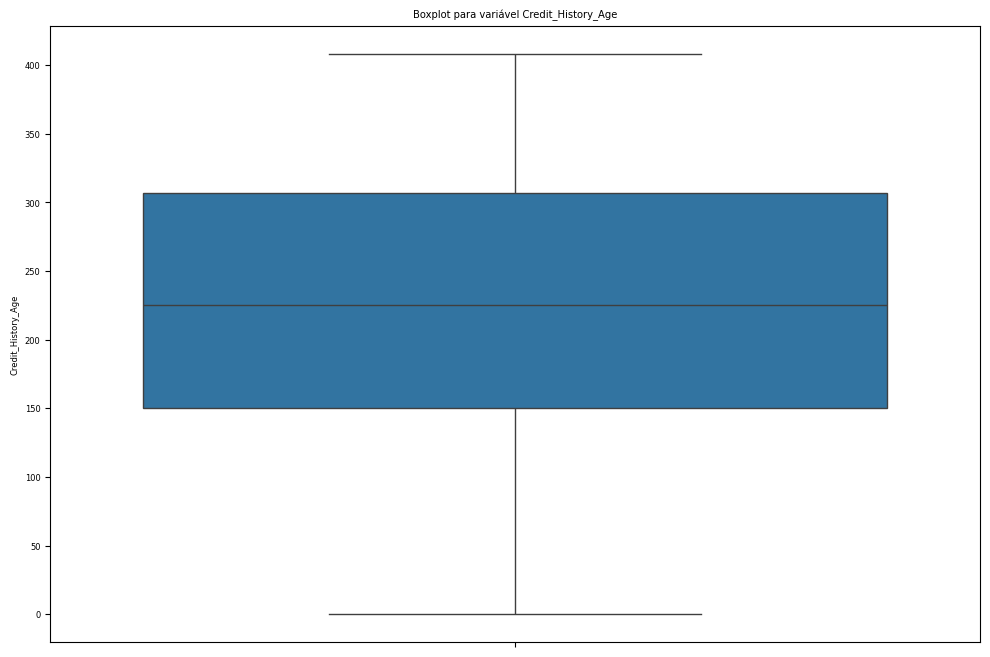

In [17]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=dataset_correlacionado['Credit_History_Age'])
plt.title("Boxplot para variável Credit_History_Age")
plt.xticks(rotation=45)
plt.show()

In [18]:
Q1 = dataset_correlacionado['Credit_History_Age'].quantile(0.25)
Q3 = dataset_correlacionado['Credit_History_Age'].quantile(0.75)
IQR = Q3 - Q1

# Limites superior e inferior para detectar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

quartis = dataset_correlacionado['Credit_History_Age'].describe().T[['25%', '50%', '75%', 'min', 'max']]

# Mostrar os quartis
print("Quartis das variáveis numéricas:")
print(quartis)

Quartis das variáveis numéricas:
25%    150.0
50%    225.0
75%    307.0
min      0.0
max    408.0
Name: Credit_History_Age, dtype: float64


Não foram identificados Outliers para serem retirados

In [19]:
dataset_correlacionado.head()

,Credit_Mix,Occupation,Payment_Behaviour,Payment_of_Min_Amount,Age,Credit_History_Age,Delay_from_due_date,Num_of_Loan,Outstanding_Debt,Monthly_Inhand_Salary,Monthly_Balance,Annual_Income
0,Bad,Lawyer,High_spent_Small_value_payments,Yes,18,133,62,2,1562.91,2706.161667,303.817399,30625.0
1,Bad,Lawyer,Low_spent_Medium_value_payments,Yes,18,132,62,2,1562.91,2706.161667,356.803602,30625.0
2,Bad,Lawyer,Low_spent_Small_value_payments,Yes,18,131,62,2,1562.91,2706.161667,349.977505,30625.0
3,Bad,Lawyer,Low_spent_Large_value_payments,Yes,18,130,65,2,1562.91,2706.161667,341.390178,17188404.0
4,Standard,Mechanic,High_spent_Medium_value_payments,Yes,26,376,8,4,202.68,4250.390000,441.878698,52312.0


# Começando com o modelo

## OneHotEncoder nas variáveis categórias

O one-hot encoder foi escolhido devido às nossas variáveis categórias não terem hierarquia e sim meramente classificação

### Occupation

In [20]:
hot_encoder = OneHotEncoder(sparse_output=False, drop='first')

encoded_occupation = hot_encoder.fit_transform(dataset_correlacionado[['Occupation']])
encoded_occupation_df = pd.DataFrame(encoded_occupation, columns=hot_encoder.get_feature_names_out(['Occupation']))

dataset_encoded = pd.concat([dataset_correlacionado, encoded_occupation_df], axis=1).drop('Occupation', axis=1)

In [21]:
dataset_encoded.head()

,Credit_Mix,Payment_Behaviour,Payment_of_Min_Amount,Age,Credit_History_Age,Delay_from_due_date,Num_of_Loan,Outstanding_Debt,Monthly_Inhand_Salary,Monthly_Balance,Annual_Income,Occupation_Architect,Occupation_Developer,Occupation_Doctor,Occupation_Engineer,Occupation_Entrepreneur,Occupation_Journalist,Occupation_Lawyer,Occupation_Manager,Occupation_Mechanic,Occupation_Media_Manager,Occupation_Musician,Occupation_Scientist,Occupation_Teacher,Occupation_Writer
0,Bad,High_spent_Small_value_payments,Yes,18,133,62,2,1562.91,2706.161667,303.817399,30625.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bad,Low_spent_Medium_value_payments,Yes,18,132,62,2,1562.91,2706.161667,356.803602,30625.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bad,Low_spent_Small_value_payments,Yes,18,131,62,2,1562.91,2706.161667,349.977505,30625.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bad,Low_spent_Large_value_payments,Yes,18,130,65,2,1562.91,2706.161667,341.390178,17188404.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Standard,High_spent_Medium_value_payments,Yes,26,376,8,4,202.68,4250.390000,441.878698,52312.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Payment_Behaviour

In [22]:
hot_encoder = OneHotEncoder(sparse_output=False, drop='first')

encoded_encoded_Payment_Behaviour = hot_encoder.fit_transform(dataset_encoded[['Payment_Behaviour']])
encoded_Payment_Behaviour_df = pd.DataFrame(encoded_encoded_Payment_Behaviour, columns=hot_encoder.get_feature_names_out(['Payment_Behaviour']))

dataset_encoded = pd.concat([dataset_encoded, encoded_Payment_Behaviour_df], axis=1).drop('Payment_Behaviour', axis=1)

In [23]:
dataset_encoded.head()

,Credit_Mix,Payment_of_Min_Amount,Age,Credit_History_Age,Delay_from_due_date,Num_of_Loan,Outstanding_Debt,Monthly_Inhand_Salary,Monthly_Balance,Annual_Income,Occupation_Architect,Occupation_Developer,Occupation_Doctor,Occupation_Engineer,Occupation_Entrepreneur,Occupation_Journalist,Occupation_Lawyer,Occupation_Manager,Occupation_Mechanic,Occupation_Media_Manager,Occupation_Musician,Occupation_Scientist,Occupation_Teacher,Occupation_Writer,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments
0,Bad,Yes,18,133,62,2,1562.91,2706.161667,303.817399,30625.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Bad,Yes,18,132,62,2,1562.91,2706.161667,356.803602,30625.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Bad,Yes,18,131,62,2,1562.91,2706.161667,349.977505,30625.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Bad,Yes,18,130,65,2,1562.91,2706.161667,341.390178,17188404.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Standard,Yes,26,376,8,4,202.68,4250.390000,441.878698,52312.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Payment_of_Min_Amount

In [24]:
dataset_encoded['Payment_of_Min_Amount'].unique()

array(['Yes', 'No', 'NM'], dtype=object)

In [25]:
dataset_encoded = pd.get_dummies(dataset_encoded, columns=['Payment_of_Min_Amount'], drop_first=False)
dataset_encoded.head()

,Credit_Mix,Age,Credit_History_Age,Delay_from_due_date,Num_of_Loan,Outstanding_Debt,Monthly_Inhand_Salary,Monthly_Balance,Annual_Income,Occupation_Architect,Occupation_Developer,Occupation_Doctor,Occupation_Engineer,Occupation_Entrepreneur,Occupation_Journalist,Occupation_Lawyer,Occupation_Manager,Occupation_Mechanic,Occupation_Media_Manager,Occupation_Musician,Occupation_Scientist,Occupation_Teacher,Occupation_Writer,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments,Payment_of_Min_Amount_NM,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes
0,Bad,18,133,62,2,1562.91,2706.161667,303.817399,30625.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,False,True
1,Bad,18,132,62,2,1562.91,2706.161667,356.803602,30625.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,False,True
2,Bad,18,131,62,2,1562.91,2706.161667,349.977505,30625.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False,False,True
3,Bad,18,130,65,2,1562.91,2706.161667,341.390178,17188404.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,False,True
4,Standard,26,376,8,4,202.68,4250.390000,441.878698,52312.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False,False,True


## Separando as variáveis de treino e teste

In [26]:
dataset_encoded.columns

Index(['Credit_Mix', 'Age', 'Credit_History_Age', 'Delay_from_due_date',
       'Num_of_Loan', 'Outstanding_Debt', 'Monthly_Inhand_Salary',
       'Monthly_Balance', 'Annual_Income', 'Occupation_Architect',
       'Occupation_Developer', 'Occupation_Doctor', 'Occupation_Engineer',
       'Occupation_Entrepreneur', 'Occupation_Journalist', 'Occupation_Lawyer',
       'Occupation_Manager', 'Occupation_Mechanic', 'Occupation_Media_Manager',
       'Occupation_Musician', 'Occupation_Scientist', 'Occupation_Teacher',
       'Occupation_Writer',
       'Payment_Behaviour_High_spent_Medium_value_payments',
       'Payment_Behaviour_High_spent_Small_value_payments',
       'Payment_Behaviour_Low_spent_Large_value_payments',
       'Payment_Behaviour_Low_spent_Medium_value_payments',
       'Payment_Behaviour_Low_spent_Small_value_payments',
       'Payment_of_Min_Amount_NM', 'Payment_of_Min_Amount_No',
       'Payment_of_Min_Amount_Yes'],
      dtype='object')

In [27]:
X = dataset_encoded.drop('Credit_Mix', axis=1)
y = dataset_encoded['Credit_Mix']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Treinando o modelo

In [29]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Avaliação do modelo

In [145]:
y_pred = model.predict(X_test)

# Acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy}")

# Relatório de classificação (precisão, recall, f1-score)
print(classification_report(y_test, y_pred))

Acurácia: 0.8987
              precision    recall  f1-score   support

         Bad       0.93      0.89      0.91      2367
        Good       0.87      0.92      0.89      3081
    Standard       0.90      0.89      0.90      4552

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [146]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3)
grid_search.fit(X_train, y_train)

print(f"Melhores parâmetros: {grid_search.best_params_}")

Melhores parâmetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}


## Plotando a importancia das variáveis

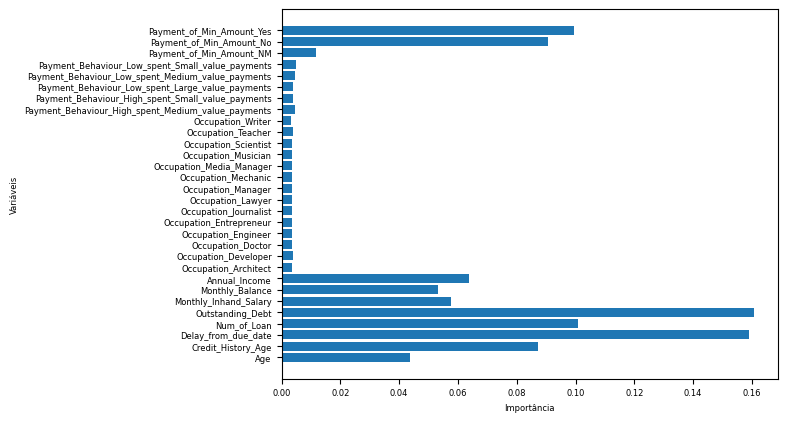

In [147]:
importances = model.feature_importances_

# Plotando a importância
plt.barh(X.columns, importances)
plt.xlabel("Importância")
plt.ylabel("Variáveis")
plt.show()

## Aprimorando mdelo

In [148]:
best_params = grid_search.best_params_

optimized_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)

optimized_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

In [149]:
y_pred_optimized = optimized_model.predict(X_test)

# Acurácia
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"Acurácia do modelo otimizado: {accuracy_optimized}")

# Relatório de classificação
print(classification_report(y_test, y_pred_optimized))

Acurácia do modelo otimizado: 0.9008
              precision    recall  f1-score   support

         Bad       0.93      0.89      0.91      2367
        Good       0.87      0.92      0.90      3081
    Standard       0.91      0.89      0.90      4552

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



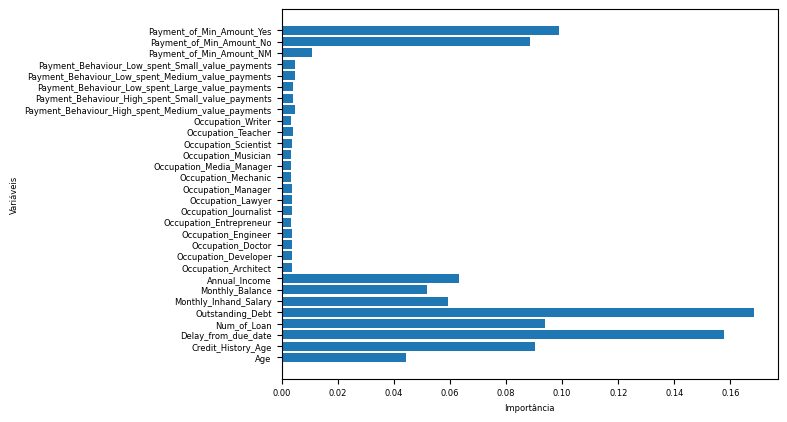

In [150]:
importances_optimized = optimized_model.feature_importances_

# Plotando a importância
plt.barh(X.columns, importances_optimized)
plt.xlabel("Importância")
plt.ylabel("Variáveis")
plt.show()


## Testando o modelo

In [154]:
cliente_ficticio = {
    'Occupation': 'Scientist',
    'Payment_Behaviour': 'Low_spent_Small_value_payments',
    'Payment_of_Min_Amount': 'No',
    'Age': 30,
    'Year_credit_history': 20,
    'Month_credit_history': 2,
    'Delay_from_due_date': 2,
    'Num_of_Loan': 2,
    'Outstanding_Debt': 500.00,
    'Monthly_Inhand_Salary': 1500.00,
    'Monthly_Balance': 300.00,
    'Annual_Income': 25000.00
}
cliente_df = pd.DataFrame([cliente_ficticio])

cliente_df['Credit_History_Age'] = (
    cliente_df['Year_credit_history'] * 12 + cliente_df['Month_credit_history']
)

selecao_colunas = [
    'Occupation', 
    'Payment_Behaviour', 
    'Payment_of_Min_Amount', 
    'Age', 
    'Credit_History_Age', 
    'Delay_from_due_date', 
    'Num_of_Loan',
    'Outstanding_Debt',
    'Monthly_Inhand_Salary',
    'Monthly_Balance',
    'Annual_Income'
]

cliente_df = cliente_df[selecao_colunas]


cliente_ficticio_encoded = pd.get_dummies(cliente_df, columns=['Occupation', 'Payment_Behaviour'], drop_first=True)
cliente_ficticio_encoded = pd.get_dummies(cliente_ficticio_encoded, columns=['Payment_of_Min_Amount'], drop_first=False)

columns_do_modelo = X_train.columns
cliente_ficticio_adjusted = cliente_ficticio_encoded.reindex(columns=columns_do_modelo, fill_value=0)

# prediction = optimized_model.predict(cliente_ficticio_adjusted)
prediction = optimized_model.predict(cliente_ficticio_adjusted)

print(f"A previsão do Credit_Mix para o cliente fictício é: {prediction[0]}")


A previsão do Credit_Mix para o cliente fictício é: Good


# Salvando o modelo

In [30]:
model_path = r'C:\Users\GabGalani\Documents\Data Projects\Analise_credito\src\model'

with open(os.path.join(model_path, 'model.pkl'), 'wb') as arquivo:
    pickle.dump(optimized_model, arquivo)

In [157]:
joblib.dump(X_train.columns, os.path.join(model_path, 'columns.joblib'))

['C:\\Users\\GabGalani\\Documents\\Data Projects\\Analise_credito\\src\\model\\columns.joblib']